In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy 
import datetime

In [126]:
L = 50
u = 0.001
k1 = 1
k2 = 0.04
eps = 0.5
alpha = 0.001
F0 = 1
m = 1
h = 0.1
eps2 = 0.33

In [128]:
@njit
def acc(x,v,t):
    xIntoLeft = np.roll(x,-1)
    xIntoRight = np.roll(x,1)
    xIntoLeft[-1] = 0
    xIntoRight[0] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t) )/m

In [129]:
@njit
def acc2(x,v,t):
    return (-x*(2*k1 + k2) + k2*u*t - f2(x,v,t) )/m

In [130]:
@njit
def f(x,v,t):
     xIntoLeft = np.roll(x,-1)
     xIntoRight = np.roll(x,1)
     xIntoLeft[-1] = 0
     xIntoRight[0] = 0
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))
     ### TODO check for v<0

In [131]:
@njit
def f2(x,v,t):
     return np.where(v==0,
     np.where(np.abs(-x*(2*k1 + k2)+ k2*u*t) < F0, -x*(2*k1 + k2) + k2*u*t ,F0*(1-eps) ),
     F0*(1-eps)/(1+alpha*np.abs(v)))
     ### TODO check for v<0

In [132]:
def tenstion(x,v,t):
    return m*acc(x,v,t) + f(x,v,t)

In [133]:
def tenstion2(x,v,t):
    return (-x*(2*k1 + k2) + k2*u*t )/m

In [134]:
@njit
def step2(x,v,t):
    k1 = v
    l1 = acc2(x,v,t)

    k2 = v + l1*h/2
    l2 = acc2(x+k1*h/2,v + l1*h/2,t + h/2)

    k3 = v + l2*h/2
    l3 = acc2(x+k2*h/2,v + l2*h/2,t + h/2)

    k4 = v + l3/2
    l4 = acc2(x+k3*h,v + l3*h, t + h)

    xNew = x +  (k1 + 2*k2 + 2*k3 + k4)*h/6
    vNew = v +  (l1 + 2*l2 + 2*l3 + l4)*h/6

    vNew = 0 if vNew < 0 else vNew 
    
    return xNew, vNew,t+h

In [135]:
@njit
def step(x,v,t):
    k1 = v
    l1 = acc(x,v,t)

    k2 = v + l1*h/2
    l2 = acc(x+k1*h/2,v + l1*h/2,t + h/2)

    k3 = v + l2*h/2
    l3 = acc(x+k2*h/2,v + l2*h/2,t + h/2)

    k4 = v + l3/2
    l4 = acc(x+k3*h,v + l3*h, t + h)

    xNew = x +  (k1 + 2*k2 + 2*k3 + k4)*h/6
    vNew = v +  (l1 + 2*l2 + 2*l3 + l4)*h/6

    vNew = np.where(vNew<0, 0, vNew)
    
    return xNew, vNew,t+h

In [193]:
def run(x,v,t,steps=1_000_000):
    xdata = np.zeros((steps,L),dtype=np.float32)
    vdata = np.zeros((steps,L),dtype=np.float32)
    tenstionData = np.zeros((steps,L),dtype=np.float32)
    for i in range(steps):
        x,v,t = step(x,v,t)
        xdata[i] = x
        vdata[i] = v
        tenstionData[i] = tenstion(x,v,t)

    slipping = np.any(vdata>0,axis=1)

    slippingR = np.roll(slipping,+1)
    slippingL = np.roll(slipping,-1)

    slippingR[0] = False
    slippingL[-1] = False 

    ends  = np.logical_xor( slipping ,(slipping *slippingL))
    starts  = np.logical_xor( slipping ,(slipping *slippingR))

    totalX = np.sum(xdata,axis = 1)

    eventsSize = totalX[np.argwhere(ends)] - totalX[np.argwhere(starts)]
    eventsBlocks = np.sum(xdata[ends]!=xdata[starts],axis=1).reshape(-1,1)


    print(np.argwhere(ends)-np.argwhere(starts))

    # time = str(datetime.datetime.now())
    # np.save("xdata-"+time,xdata)
    # np.save("vdata-"+time,vdata)

    ls = np.sum(tenstionData[np.argwhere(starts)] >= (1-eps2),axis=2)

    


    return x,v,t,eventsSize,eventsBlocks,ls


In [194]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float32) 
v = np.zeros(L,dtype=np.float32)
t = 0

In [195]:
dataDic = {}
for i in range(L):
    dataDic[i] = []


In [196]:
x,v,t,eventsSize,eventsBlocks,ls= run(x,v,t,1_000_000)

In [176]:
for j in range(100):
    x,v,t,eventsSize,eventsBlocks,ls= run(x,v,t,10_000_000)



    time = str(datetime.datetime.now())
    
    np.save("eventsSize-"+time,eventsSize)
    np.save("eventsBlocks-"+time,eventsBlocks)
    np.save("ls-"+time,ls)

    for i in range(eventsSize.shape[0]):
        dataDic[int(ls[i])].append(float(eventsSize[i]))

    print(j)

0
1
2
3
4
5
6
7
8
9


In [184]:
num = 0
for i in list(dataDic.values()):
    num += len(i)

print(num)

237


In [124]:
# for eps2 in np.arange(0.32,0.34,0.001):
#     x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float32) 
#     v = np.zeros(L,dtype=np.float32)
#     t = 0

#     x,v,t,eventsSize,eventsBlocks,ls= run(x,v,t,10_000_000)

#     par = np.linalg.norm(ls[:,0]- eventsBlocks[:,0])
#     print(eps2, par)

0.32 318.3834166535688
0.321 311.3647378878989
0.322 261.9236529983499
0.323 274.7544358149655
0.324 288.5359596306845
0.325 299.2072860075436
0.326 279.4995527724508
0.327 320.99532706879086
0.328 280.53520278211073
0.329 301.18266882408756
0.33 259.5399776527693
0.331 277.36618395182927
0.332 279.62296043064845
0.333 277.05956038368356
0.334 276.31503759296197
0.335 283.4572278140037
0.336 295.1796063416306


KeyboardInterrupt: 

<BarContainer object of 15 artists>

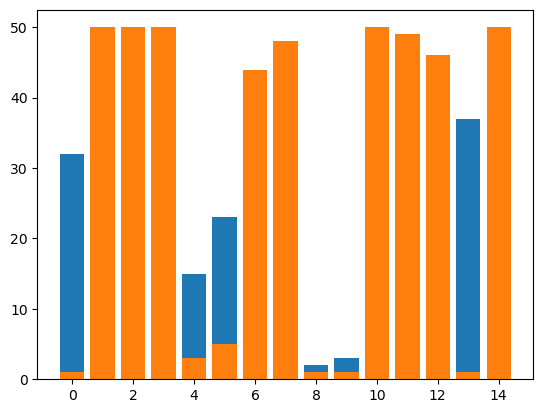

In [142]:
plt.bar(np.arange(eventsSize.shape[0]),ls[:,0])
plt.bar(np.arange(eventsSize.shape[0]),eventsBlocks[:,0])

<BarContainer object of 15 artists>

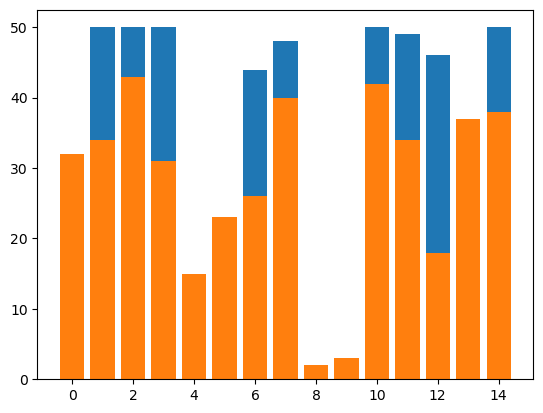

In [141]:
plt.bar(np.arange(eventsSize.shape[0]),eventsBlocks[:,0])
plt.bar(np.arange(eventsSize.shape[0]),ls[:,0])


In [15]:
x = 0.1*np.random.uniform(-1,1,L).astype(dtype=np.float32) 
v = np.zeros(L,dtype=np.float32)
t = 0

In [16]:
x,v,t,eventsSize,eventsBlock = run(x,v,t,1_000_000)

/tmp/ipykernel_6185/3979528276.py:4: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  l1 = acc(x,v,t)


In [24]:
tenstion(x,v,t)

array([ 0.92941733,  0.39425291,  0.4371245 ,  0.71820021,  0.70737958,
        0.60290386,  0.62557907,  0.61770189,  0.61775298,  0.67026785,
        0.64546022,  0.6365137 ,  0.62800613,  0.62532608,  0.6189285 ,
        0.62843162,  0.64384358,  0.59178559,  0.7004657 ,  0.59966988,
        0.60100563,  0.58277573,  0.56930126,  0.57896695,  0.59328478,
        0.66335909,  0.62447646,  0.54804957,  0.59503295,  0.56122593,
        0.57973318,  0.60369594,  0.6053518 ,  0.55898939,  0.53016622,
        0.52690777,  0.58243967,  0.58768241,  0.58523719,  0.5481633 ,
        0.43488768,  0.33948725,  0.40667135,  0.29418131,  0.22082487,
        0.59470805,  0.46832282,  0.39387153,  0.29062339, -0.11250414])

In [13]:
parts = 2000
steps = 1_000_000
eventsSizes = np.array([]).reshape((0,1))
eventsBlocks = np.array([]).reshape((0,1))
for p in range(parts):
    x,v,t,eventsSize,eventsBlock = run(x,v,t,steps)
    eventsSizes = np.concatenate((eventsSizes,eventsSize))
    eventsBlocks = np.concatenate((eventsBlocks,eventsBlock))
    print(p)

np.save("eventsSizes",eventsSizes)
np.save("eventsBlocks",eventsBlocks)

    

0
1


In [ ]:
dists = []
for i in range(L):
    dists.append(eventsSizes[eventsBlocks==i])

In [ ]:
plt.hist(eventsSizes[eventsBlocks==1],bins=300)

In [ ]:
plt.hist(eventsSizes)

In [ ]:
freq,size = np.histogram(eventsSizes)

In [ ]:
#slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[:-1]),np.log(freq))

plt.title("frequency vs size")
plt.xlabel("event size")
plt.ylabel("event frequency")
plt.scatter(np.log(size[:-1]),np.log(freq))
#plt.plot([np.log(size[0]),np.log(size[-2])],[intercept + slope.astype(np.float32)*np.log(size[0]), intercept + slope.astype(np.float32)*np.log(size[-2])])
#plt.text(-1,10,s = f"slope = {np.round(slope,3)}, intercept = {np.round(intercept,3)}, rval = {np.round(rvalue,3)}")
plt.savefig("plot.png")

In [ ]:
x = 0
v = 0
t = 0
steps = 100_000
xData = np.zeros(steps)
vData = np.zeros(steps)

In [ ]:
for i in range(steps):
    xData[i] = x
    vData[i] = v
    x,v,t = step2(x,v,t)


In [ ]:
plt.plot(np.arange(steps),xData)

In [ ]:
plt.plot(np.arange(steps),vData)

In [ ]:
tensionData= np.zeros(steps)
for i in range(steps):
    tensionData[i] = tenstion(xData[i],vData[i],i*h)

In [ ]:
fData= np.zeros(steps)
for i in range(steps):
    fData[i] = f2(xData[i],vData[i],i*h)

In [ ]:
plt.plot(np.arange(9900,10100),xData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),vData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),fData[9900:10100])

In [ ]:
plt.plot(np.arange(9900,10100),tensionData[9900:10100])

In [ ]:
plt.plot(np.arange(steps),tensionData)